In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

In [2]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']
print(indices)

['jobs_archive_2016-01-01', 'jobs_archive_2016-01-02', 'jobs_archive_2016-01-03', 'jobs_archive_2016-01-04', 'jobs_archive_2016-01-05', 'jobs_archive_2016-01-06', 'jobs_archive_2016-01-07', 'jobs_archive_2016-01-08', 'jobs_archive_2016-01-09', 'jobs_archive_2016-01-10', 'jobs_archive_2016-01-11', 'jobs_archive_2016-01-12', 'jobs_archive_2016-01-13', 'jobs_archive_2016-01-14', 'jobs_archive_2016-01-15', 'jobs_archive_2016-01-16', 'jobs_archive_2016-01-17', 'jobs_archive_2016-01-18', 'jobs_archive_2016-01-19', 'jobs_archive_2016-01-20', 'jobs_archive_2016-01-21', 'jobs_archive_2016-01-22', 'jobs_archive_2016-01-23', 'jobs_archive_2016-01-24', 'jobs_archive_2016-01-25', 'jobs_archive_2016-01-26', 'jobs_archive_2016-01-27', 'jobs_archive_2016-01-28', 'jobs_archive_2016-01-29', 'jobs_archive_2016-01-30', 'jobs_archive_2016-01-31', 'jobs_archive_2016-02-01', 'jobs_archive_2016-02-02', 'jobs_archive_2016-02-03', 'jobs_archive_2016-02-04', 'jobs_archive_2016-02-05', 'jobs_archive_2016-02-06', 

In [3]:
def time_filter(indices, last_days=1, pattern=''):
    if last_days == 0:
        return ["jobs_archive_*"]
    filtered = []
    if pattern:
        for i in indices:
            if pattern in i:
                filtered.append(i.rstrip())
        return filtered
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days <= last_days:
            filtered.append(i.rstrip())
    return filtered

In [4]:
ind = time_filter(indices, 1, "jobs_archive_2017-0" )
#ind1 = ','.join(ind)
#ind = time_filter(indices, 1, "jobs_archive_2016-02" )
#ind2 = ','.join(ind)
#ind = time_filter(indices, 1, "jobs_archive_2016-03" )
#ind3 = ','.join(ind)

#ind = ind1 + "," + ind2 + "," + ind3
print(ind)

['jobs_archive_2017-01-01', 'jobs_archive_2017-01-02', 'jobs_archive_2017-01-03', 'jobs_archive_2017-01-04', 'jobs_archive_2017-01-05', 'jobs_archive_2017-01-06', 'jobs_archive_2017-01-07', 'jobs_archive_2017-01-08', 'jobs_archive_2017-01-09', 'jobs_archive_2017-01-10', 'jobs_archive_2017-01-11', 'jobs_archive_2017-01-12', 'jobs_archive_2017-01-13', 'jobs_archive_2017-01-14', 'jobs_archive_2017-01-15', 'jobs_archive_2017-01-16', 'jobs_archive_2017-01-17', 'jobs_archive_2017-01-18', 'jobs_archive_2017-01-19', 'jobs_archive_2017-01-20', 'jobs_archive_2017-01-21', 'jobs_archive_2017-01-22', 'jobs_archive_2017-01-23', 'jobs_archive_2017-01-24', 'jobs_archive_2017-01-25', 'jobs_archive_2017-01-26', 'jobs_archive_2017-01-27', 'jobs_archive_2017-01-28', 'jobs_archive_2017-01-29', 'jobs_archive_2017-01-30', 'jobs_archive_2017-01-31', 'jobs_archive_2017-02-01', 'jobs_archive_2017-02-02', 'jobs_archive_2017-02-03', 'jobs_archive_2017-02-04', 'jobs_archive_2017-02-05', 'jobs_archive_2017-02-06', 

In [5]:
#q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:reprocessing AND proddblock:*.00283429.*"
#q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:pile"
q = "NOT produsername:gangarbt AND jobstatus:finished AND NOT transformation:*pandaserver* AND pilotid:*68.0* AND processingtype:reprocessing"

In [22]:
myquery = {
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "NOT produsername:gangarbt",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "match": {
                  "processingtype": {
                    "query": "pile",
                    "type": "phrase"
                  }
                }
              }
            },
            {
              "query": {
                "match": {
                  "jobstatus": {
                    "query": "finished",
                    "type": "phrase"
                  }
                }
              }
            },
                     ]
        }
      }
    }
  },
  "size": 0,
  "aggs": {
    "2": {
      "histogram": {
        "script": "(doc['nevents'].value) ? doc['wall_time'].value*10/doc['nevents'].value : 0",
        "lang": "expression",
        "interval": 5
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "computingsite",
            "size": 10
          }
        }
      }
    }
  }
}


myqueryPile = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND NOT processingtype:*panda-client* AND NOT processingtype:*jedi*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
        {
          "match": {
            "jobstatus": {
              "query": "finished",
              "type": "phrase"
            }
          }
        },
        {
          "match": {
            "processingtype": {
              "query": "pile",
              "type": "phrase"
            }
          }
        },
      ],
      "must_not": []
    }
  },
      "aggs": {
        "2": {
          "histogram": {
                        "script": {
          "inline": "doc['IOcharReadRate'].value/1048576.",
          "lang": "expression"
        },
            "interval": 0.1,
            "min_doc_count": 1
          },
          "aggs": {
            "3": {
              "significant_terms": {
                "field": "homepackage",
                "size": 20
              }
            }
          }
        }
      }

  }


myqueryPile2 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND NOT processingtype:*panda-client* AND NOT processingtype:*jedi*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
        {
          "match": {
            "jobstatus": {
              "query": "finished",
              "type": "phrase"
            }
          }
        },
        {
          "match": {
            "processingtype": {
              "query": "pile",
              "type": "phrase"
            }
          }
        },
      ],
      "must_not": []
    }
  },
      "aggs": {
        "2": {
                  "histogram": {
        "script": {
          "inline": "doc['IOcharRead'].value/1048576.",
          "lang": "expression"
        },
        "interval": 1,
            "min_doc_count": 1
          },
          "aggs": {
            "3": {
              "significant_terms": {
                "field": "homepackage",
                "size": 20
              }
            }
          }
        }
      }

  }

myqueryPile3 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND NOT processingtype:*panda-client* AND NOT processingtype:*jedi*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
        {
          "match": {
            "jobstatus": {
              "query": "finished",
              "type": "phrase"
            }
          }
        },
        {
          "match": {
            "processingtype": {
              "query": "pile",
              "type": "phrase"
            }
          }
        },
      ],
      "must_not": []
    }
  },
      "aggs": {
        "2": {
                  "histogram": {
        "script": {
          "inline": "doc['inputfilebytes'].value/1073741824.",
          "lang": "expression"
        },
        "interval": 0.5,
            "min_doc_count": 1
          },
          "aggs": {
            "3": {
              "significant_terms": {
                "field": "homepackage",
                "size": 20
              }
            }
          }
        }
      }

  }

myqueryWalltime = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND jobstatus:finished AND NOT transformation:*pandaserver* AND pilotid:*68.0* AND processingtype:reprocessing AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 0.5,
        "min_doc_count": 1
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "computingsite",
            "size": 20
          }
        }
      }
    }
  }
}

myqueryWalltime2 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND jobstatus:finished AND NOT transformation:*pandaserver* AND pilotid:*68.0* AND processingtype:reprocessing AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value) ? doc['wall_time'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "computingsite",
            "size": 20
          }
        }
      }
    }
  }
}

myqueryWalltime3 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "jobstatus:finished AND pilotid:*68* AND processingtype:reprocessing AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      }
    }
  }
}


myqueryWalltimeReco = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "jobstatus:finished AND pilotid:*68* AND processingtype:reprocessing AND homepackage:*21.0.20* AND transformation:Reco_tf.py AND avgswap:[0 TO 1000000] ",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      }
    }
  }
}

myqueryWalltimeReco2015 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "jobstatus:finished AND processingtype:reprocessing AND homepackage:*20.7.3.8 AND NOT transformation:Reco_tf.py",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['corecount'].value) ? doc['wall_time'].value*doc['corecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      }
    }
  }
}




In [23]:
res = es.search(index=ind, body=myqueryWalltimeReco, request_timeout=600)

In [24]:
print(res)

{'timed_out': False, 'aggregations': {'2': {'buckets': [{'doc_count': 1, 'key': -30.0}, {'doc_count': 1, 'key': -23.0}, {'doc_count': 1, 'key': -19.0}, {'doc_count': 1, 'key': -18.0}, {'doc_count': 1, 'key': -9.0}, {'doc_count': 2, 'key': -1.0}, {'doc_count': 6961, 'key': 0.0}, {'doc_count': 985, 'key': 1.0}, {'doc_count': 2969, 'key': 2.0}, {'doc_count': 8436, 'key': 3.0}, {'doc_count': 19433, 'key': 4.0}, {'doc_count': 21517, 'key': 5.0}, {'doc_count': 20968, 'key': 6.0}, {'doc_count': 17724, 'key': 7.0}, {'doc_count': 24284, 'key': 8.0}, {'doc_count': 29277, 'key': 9.0}, {'doc_count': 40788, 'key': 10.0}, {'doc_count': 55470, 'key': 11.0}, {'doc_count': 77050, 'key': 12.0}, {'doc_count': 90096, 'key': 13.0}, {'doc_count': 108637, 'key': 14.0}, {'doc_count': 128532, 'key': 15.0}, {'doc_count': 145126, 'key': 16.0}, {'doc_count': 148428, 'key': 17.0}, {'doc_count': 148131, 'key': 18.0}, {'doc_count': 146734, 'key': 19.0}, {'doc_count': 145414, 'key': 20.0}, {'doc_count': 141043, 'key'

[[1, 1, 1, 1, 1, 2, 6961, 985, 2969, 8436, 19433, 21517, 20968, 17724, 24284, 29277, 40788, 55470, 77050, 90096, 108637, 128532, 145126, 148428, 148131, 146734, 145414, 141043, 135254, 125612, 118031, 108970, 99552, 91508, 84362, 77141, 70704, 63502, 57443, 52169, 47699, 43430, 40070, 36638, 33508, 30927, 28396, 25493, 23413, 21524, 20261, 19041, 17778, 16508, 15970, 14552, 13940, 13183, 12501, 12402, 11504, 11141, 10805, 10217, 9584, 8886, 8461, 8117, 7707, 7106, 7048, 6731, 6440, 6203, 5827, 5340, 5157, 4932, 4571, 4191, 4127, 3953, 3692, 3602, 3419, 3301, 3194, 3132, 3066, 2892, 2943, 2891, 2754, 2587, 2647, 2506, 2489, 2404, 2236, 2168, 2212, 2062, 2215, 1996, 2126, 1907, 1833, 1936, 1852, 1828, 1783, 1753, 1727, 1661, 1688, 1542, 1583, 1505, 1443, 1517, 1402, 1429, 1358, 1369, 1341, 1312, 1398, 1258, 1306, 1254, 1220, 1225, 1160, 1182, 1173, 1084, 1137, 1069, 1078, 1017, 955, 963, 970, 907, 901, 819, 946, 872, 892, 849, 800, 815, 786, 819, 791, 813, 782, 766, 812, 760, 753, 675, 7

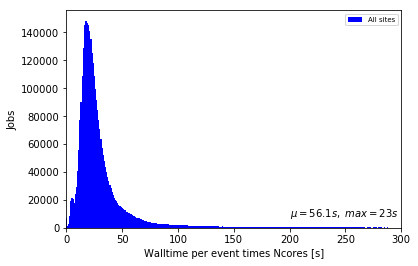

In [25]:
hists = []
xbins = []
rels = []

hists =[[]]
rels = ['All sites']

# First loop: determine AtlasRelease numbers and initialize histograms
#for r in res['aggregations']['2']['buckets']:
#    for e in r['3']['buckets']:
#        if not e['key'] in rels:
#            rels.append(e['key'])
#            hists.append([])

# Now loop again and fill the histogram bins            
xbin = 0
for r in res['aggregations']['2']['buckets']:
    x = r['key']
    #print(x)
    #print(r['doc_count'])
    #if x>199: # This is the x-axis cut for inputfilebytes !
    #if x>199: # This is the x-axis cut for total !
    #if x>17.9: # This is the x-axis cut for rate !
    #if x>300:
    #    continue
    xbins.append(x)
    for hist in hists:
        hist.append(r['doc_count'])
    #for e in r['3']['buckets']:
    #    #print(e)
    #    for rel, hist in zip(rels,hists):
    #        if e['key'] == rel:
    #            hist[xbin] = e['doc_count']
    xbin = xbin + 1

print(hists)
print(xbins)

allsites = hists[0]
ibin = 0
sum = 0
wsum = 0
max = 0
for bin in allsites:
    if bin > max:
        max = bin
        maxbin = ibin
    sum = sum + bin
    wsum = wsum + bin * ibin
    ibin = ibin +1

mean = wsum/sum
print (mean, sum, wsum)
print (max, maxbin)
print(len(xbins),len(hists))

# Initialisation for histogram stacking
y_offset = np.array([0.0] * len(xbins))
#colors = plt.cm.BuPu(np.linspace(0, 0.5, len(hists)))
allcolors = ('#ff3333', '#33ff33', '#3333ff', '#33ffff', "#ffffff", '#000000', '#ff0000', '#00ff00', '#0000ff')
#allcolors = ('accent', 'dark2', 'paired', 'pastel1','pastel2', 'set1', 'set2', 'set3', 'vega10','vega20', 'vega20b', 'vega20c')
from itertools import cycle, islice
allcolors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(hists)))

colors = allcolors[:len(hists)]

for hist, rel, icolor in zip(hists,rels, colors):
    #print(hist,xbins)
    #plt.plot(xbins,hist)
    plt.bar(xbins, hist, bottom=y_offset, log=False, label=rel, color=icolor, width=1)
    y_offset = y_offset + hist
    #plt.hist(hist,bins=xbins, log=True, label=rels[i])
    plt.xlabel('Walltime per event times Ncores [s]')
    plt.ylabel('Jobs')

plt.legend(loc='upper right',prop={'size':7})
plt.xlim([0,300])
plt.text(200, 8000, r'$\mu=%2.1f s,\ max=%s s$'%(mean, maxbin))

plt.savefig("walltimes.png")
plt.show()

